In [1]:
from validation.machine_learning import MLPipelines

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
param_grid = {}
csv_dir = 'data/composite_dataset.csv'
label = 'group'

mlpipe = MLPipelines(model=model, param_grid=param_grid, label=label, csv_dir=csv_dir)
mlpipe.X

,1014.6391_19.2,102.0461_0.94,1020.7329_29.96,1026.743_24.96,1028.6159_19.2,1034.6116_1.02,1043.5805_19.2,1043.5815_18.42,1046.5904_19.2,1052.7966_35.63,...,Succinic acid,Threitol,Threonine,trans-4-hydroxy-L-proline,Trans-aconitic acid,Tryptophan,Tyrosine,Urea,Uric acid,Valine
12,16876,239553,29039,18318,20935,3100,171854,17408,61443,212831,...,857.76,2197.53,24447.77,6405.79,1394.76,32045.44,65461.58,3860294.72,58341.17,179807.52
15,24975,511854,10877,9677,27443,2279,219430,25666,78598,174309,...,992.82,1454.86,21656.99,6685.78,1795.11,35471.25,51331.44,3230542.69,49711.39,154433.49
19,15809,295684,3738,3733,16316,2410,161321,14260,52448,234907,...,1179.49,3799.36,25821.64,10985.81,2930.77,62623.37,95582.13,4912070.89,65151.55,258668.84
2,14274,316320,4516,2945,18558,4198,149677,12523,48566,166061,...,1236.32,3445.45,31701.67,14229.90,2779.67,30834.64,113637.54,3507068.54,89706.31,319385.40
21,25926,240802,23787,18246,29704,4356,261080,38268,91711,220839,...,1195.36,2466.10,18129.38,8825.26,2788.51,34267.17,43127.44,1521851.33,81950.87,178226.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C67B,17537,194095,2666,23667,20677,2951,191446,19137,64816,132283,...,1604.23,4227.57,35054.69,9863.91,3020.93,70524.77,99189.49,5023218.83,126409.81,268081.49
C68A,16612,454655,38099,31766,18060,2987,157424,13221,54683,210031,...,1894.29,4477.26,37623.36,7349.35,4862.61,112452.09,151345.97,4972299.70,206999.12,348981.19
C70A,29449,530845,67301,61017,31321,5374,294286,46342,101507,168129,...,1072.91,3195.13,25158.98,8134.61,2571.86,58988.08,95384.04,4448295.24,72978.70,209767.21
C71B,23618,215444,4455,22146,23483,3155,239959,32770,75356,108342,...,1302.53,3877.54,53881.38,19812.10,5283.45,98886.23,125451.06,8405689.41,218454.81,350066.12


In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model  import LogisticRegression
from validation import boostrap, nested_cv
from validation.bayesian_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from dataloader import DataLoader

In [2]:
PATH = 'data/composite_dataset.csv'

dataloader = DataLoader(label='group', csv_dir=PATH)
dataloader.normalize(method='standard')
dataloader.feature_selection(n_features=25)
dataloader.encode_categorical()
print(dataloader)

100%|██████████| 25/25 [00:05<00:00,  4.22it/s]

Number of rows: 71 
Number of columns: 1431


In [ ]:
lr = LogisticRegression()
param_grid = {'penalty': ['l1'], 'C': [1, 10, 100, 200, 500], 
            'solver': ['liblinear'], 'max_iter': [10000]}
lr_scores = boostrap(estimator=lr, X=dataloader.X, param_grid=param_grid, y=dataloader.y, scoring='mcc', n_iterations=5) 

Average mcc: 0.9745743121887939
Standard deviation mcc: 0.05085137562241222


In [ ]:
clf, nested_scores = nested_cv(lr, param_grid=param_grid, inner_scoring='matthews_corrcoef', outer_scoring='matthews_corrcoef', 
                               X=dataloader.X, y=dataloader.y, num_trials=10)

Performing nested cross-validation for LogisticRegression...


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


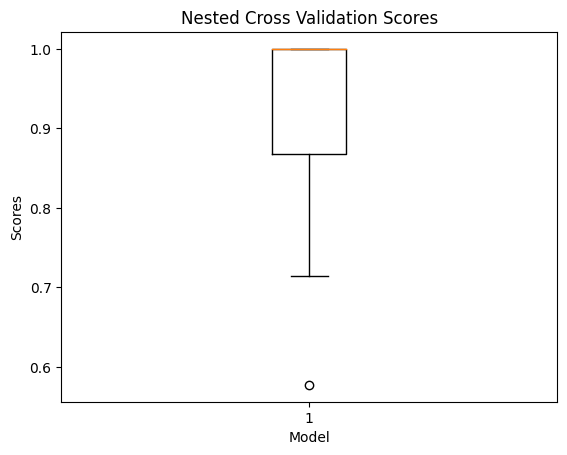

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot(nested_scores)
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Nested Cross Validation Scores')
plt.show()



In [ ]:
import sklearn
# list(sklearn.metrics.SCORERS.keys())
lr.fit(dataloader.X, dataloader.y)
y_pred = lr.predict(dataloader.X)
y_true = dataloader.y

from sklearn.metrics import get_scorer

# Suppose you have a scorer key, for example, 'matthews_corrcoef'
scorer_key = 'matthews_corrcoef'

# Get the scorer object using the key
scorer = get_scorer(scorer_key)

# Now, if you have true labels y_true and predicted labels y_pred
score = scorer._score_func(y_true, y_pred)  # Replace y_true and y_pred with your actual data

print("Score using the scorer object:", score)


Score using the scorer object: 1.0
